In [ ]:
import numpy as np
from numba import njit
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation


%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['font.size'] = 12
plt.rcParams["animation.html"] = "jshtml"

# Main formulas from «Love and death: A Freund model with frailty»

**Definition of survival functions for hidden variables:**

$$ S_{12}(x_1,x_2) = \text {Pr} \left ( X_1 > x_1, X_2 > x_2 \right ) \\
S_{3}(x_3;z) = \text {Pr} \left ( X_3 > x_3 | X_2 = \min(X_1,X_2) = z \right ) \\
S_{4}(x_4;z) = \text {Pr} \left ( X_4 > x_4 | X_1 = \min(X_1,X_2) = z \right ) $$

**Definition of residual lifetimes**:

$$ Y_1 = \min(X_1,X_2) + X_3\mathbb 1_{X_2<X_1} \\
 Y_2 = \min(X_1,X_2) + X_4\mathbb 1_{X_1<X_2}$$

**Mortality density**:

$$ f(y_1,y_2) = \begin{cases}
\left [ -\frac{\partial S_{12}}{\partial x_1}(y_1,y_2) \right]\left[ -\frac{\partial S_{4}}{\partial x_4}(y_2-y_1,y_1) \right], & y_1<y_2 \\
\left [ -\frac{\partial S_{12}}{\partial x_2}(y_1,y_2) \right]\left[ -\frac{\partial S_{3}}{\partial x_3}(y_1-y_2,y_2) \right], & y_1>y_2
\end{cases}$$

**Mortality intensity**:
$$ \lambda_1(y|Y_1>y,Y_2>y) = -\frac{\partial \log S_{12}}{\partial x_1}(y,y)  \\
\lambda_2(y|Y_1>y,Y_2>y) =  -\frac{\partial \log S_{12}}{\partial x_2}(y,y) \\
\lambda_{1|2}(y|Y_1>y,Y_2 = y^*) =  -\frac{\partial \log S_{3}}{\partial x_3}(y-y^*,y^*) \\
\lambda_{2|1}(y|Y_1 = y^*,Y_2 > y) =  -\frac{\partial \log S_{4}}{\partial x_4}(y-y^*,y^*)
$$

**Mortality intensity jump**:
$$ \gamma_{1|2}(y) = \lambda_{1|2}(y|Y_1>y,Y_2 = y)/\lambda_1(y|Y_1>y,Y_2>y) \\
\gamma_{2|1}(y) = \lambda_{2|1}(y|Y_1 = y,Y_2 > y)/\lambda_2(y|Y_1>y,Y_2>y)
$$

**Cumulative intensities**:
$$ A_1(x_1;F) = \int_0^{x_1} a_1(u;F)du\\
A_2(x_2;F) = \int_0^{x_2} a_2(u;F)du \\
A_3(x_3;z;F) = \int_0^{x_3} a_3(u;z;F)du \\
A_4(x_4;z;F) = \int_0^{x_4} a_4(u;z;F)du $$

**Conditional survival functions**:
$$S_{12}(x_1,x_2;F) = \exp \left[- \left( A_1(x_1;F) +  A_2(x_2;F)\right) \right] \\
S_{3}(x_3;z;F) = \exp \left[- A_3(x_3;z;F)\right] \\
S_{4}(x_4;z;F) = \exp \left[- A_4(x_4;z;F)\right]$$

**Conditional density**:

$$ f(y_1,y_2;F) = \begin{cases}
a_1(y_1;F) \times \exp \left[- \left( A_1(y_1;F) +  A_2(y_1;F)\right) \right] \times a_4(y_2-y_1;y_1;F) \times\exp \left[- A_4(y_2-y_1;y_1;F)\right], & y_1<y_2 \\
a_2(y_2;F) \times \exp \left[- \left( A_1(y_2;F) +  A_2(y_2;F)\right) \right] \times a_3(y_1-y_2;y_2;F) \times\exp \left[- A_3(y_1-y_2;y_2;F)\right], & y_1>y_2
\end{cases} $$

**Unconditional survival functions through conditional intensities**:
$$S_{12}(x_1,x_2) = \text E S_{12}(x_1,x_2;F) = \text E \exp \left [- \left( A_1(x_1;F) +  A_2(x_2;F)\right)  \right] \\
S_3(x_3;z) = \text {Pr} \left( X_3 > x_3| X_2 = z, X_1 >z\right) =
\frac  {\text E\left[ a_2(z;F)\exp\left( - \left[A_1(z;F) + A_2(z;F) + A_3(x_3;z;F) \right]\right)\right]}
{\text E\left[ a_2(z;F)\exp\left( - \left[A_1(z;F) + A_2(z;F)\right]\right)\right]} \\
S_4(x_4;z) = \text {Pr} \left( X_4 > x_4| X_1 = z, X_2 >z\right) =
\frac  {\text E\left[ a_1(z;F)\exp\left( - \left[A_1(z;F) + A_2(z;F) + A_4(x_4;z;F) \right]\right)\right]}
{\text E\left[ a_1(z;F)\exp\left( - \left[A_1(z;F) + A_2(z;F)\right]\right)\right]}
$$

**Density given $F$ and survival to $z_0$**:

$$ \widetilde f(\widetilde y_1,\widetilde y_2;z_0;F) = f(y_1+z_0,y_2+z_0;F) / S_{12}(z_0,z_0;F)$$

**Density given survival to $z_0$ for Proportional Frailty and the given model**:

$$ \widetilde f(\widetilde y_1,\widetilde y_2;z_0) = \int \widetilde f(\widetilde y_1,\widetilde y_2;z_0;F) g_{z_0}(F)dF =
\int \frac {f(y_1+z_0,y_2+z_0;F)} {S_{12}(z_0,z_0;F)} \frac {F^{k-1}\exp(-F/\theta(z_0))}{\theta(z_0)^k\Gamma(k)}dF = \\
\frac {a_1(y_1 + z_0) a_2(y_2+z_0) \gamma} {\Gamma(k)\theta(z_0)^k}
\int  F^{k+1} \exp \left [ - F \left( 1/\theta(z_0) + A_1(y_1 + z_0) + A_2(y_1 + z_0) + \gamma(A_2(y_2 + z_0)-A_2(y_1 + z_0)) - (A_1(z_0) + A_2(z_0))  \right) \right] dF = \\
\left \{  \int F^{k+1} \exp(-Fn)dF = \frac {\Gamma(k+2)}{n^{k+2}}\right \} = \\
\frac {a_1(y_1 + z_0) a_2(y_2+z_0) \gamma \Gamma(k+2)} {\Gamma(k)\theta(z_0)^k \left( 1/\theta(z_0) + A_1(y_1 + z_0) + A_2(y_1 + z_0) + \gamma(A_2(y_2 + z_0)-A_2(y_1 + z_0)) - (A_1(z_0) + A_2(z_0))  \right) ^{k+2}}, y_1<y_2$$

Symmetrically,

$$ \widetilde f(\widetilde y_1,\widetilde y_2;z_0) =
\frac {a_1(y_1 + z_0) a_2(y_2+z_0) \gamma \Gamma(k+2)} {\Gamma(k)\theta(z_0)^k \left( 1/\theta(z_0) + A_1(y_2 + z_0) + A_2(y_2 + z_0) + \gamma(A_1(y_1 + z_0)-A_1(y_2 + z_0)) - (A_1(z_0) + A_2(z_0))  \right) ^{k+2}}, y_2<y_1
$$

In our case, $\theta(z_0 = 30) = 1/k$.

Note that the formula is valid for an arbitrary gamma distribution in place of $g_{z_0}(F)$.

**Model specification**:

 + Age at marriage: $y^*_{1,0} = y^*_{2,0} = 30$
 + Duration of marriage: $z_0 = 30$
 + Frailty distribution given survival to $z_0$: $g_{z_0}(F) \sim \Gamma(1/k,k) \propto F^{k-1}\exp(-Fk)$
     + $\text E(F|z_0) = 1$
     + $k \in \{2,5,10\}$
 + risk-free rate: $r = 1\%$

**Mortality models**:

$$ a_1(x_1;F) = \exp(\alpha_1 x_1 + \beta_1)F \\
a_2(x_2;F) = \exp(\alpha_2 x_2 + \beta_2)F \\
a_3(x_3;z;F) = \gamma a_1(x_3+z;F) =\gamma\exp(\alpha_1 (x_3 + z) + \beta_1)F \\
a_4(x_4;z;F) = \gamma a_2(x_4+z;F) = \gamma\exp(\alpha_2 (x_4 + z) + \beta_2)F \\
\alpha_1 = 0.089, \beta_1 = -7.613, \alpha_2 = 0.081, \beta_2 = -6.934, \gamma \in [1,2]
$$

In [ ]:
from libs.single_static_frailty.math import *
from libs.single_static_frailty.plotting import *

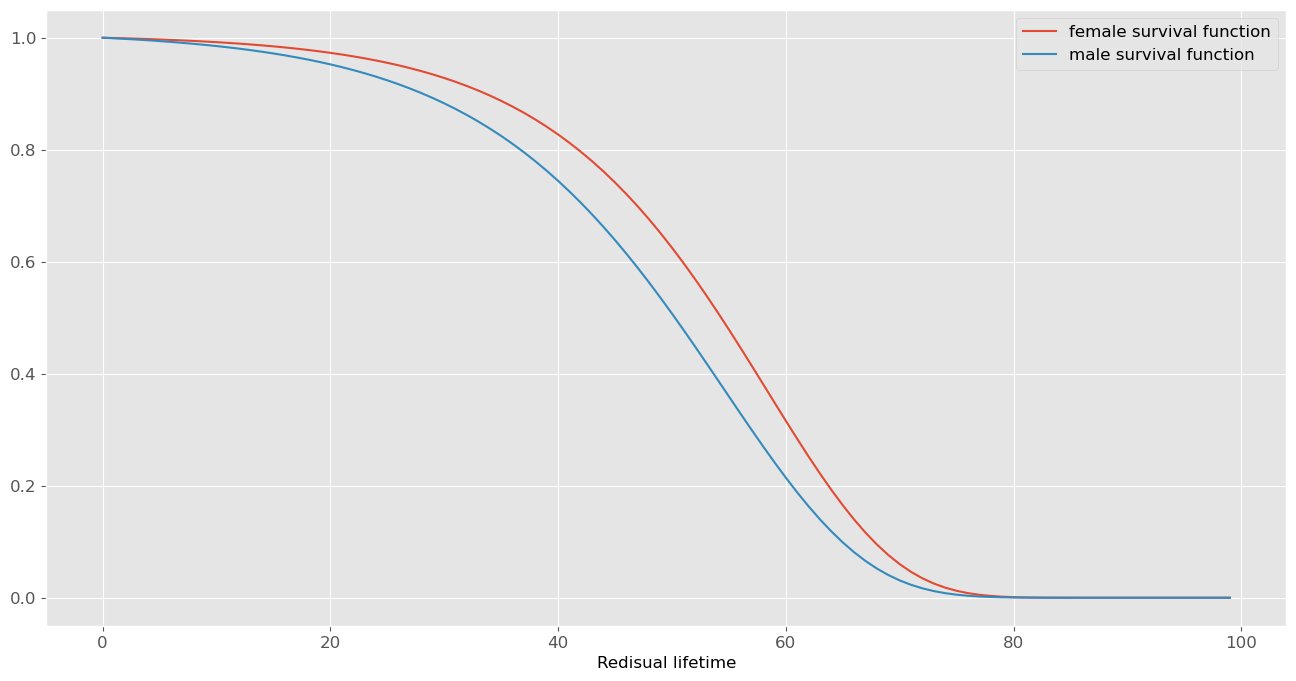

In [ ]:
a1 = 0.089
b1 = -7.613
a2 = 0.081
b2 = -6.934
x = np.arange(100)

plt.plot(x,gompertz_survival_function(x,a1,b1), label = 'female survival function')
plt.plot(x,gompertz_survival_function(x,a2,b2), label = 'male survival function')
plt.xlabel('Redisual lifetime')
plt.legend()
plt.show()

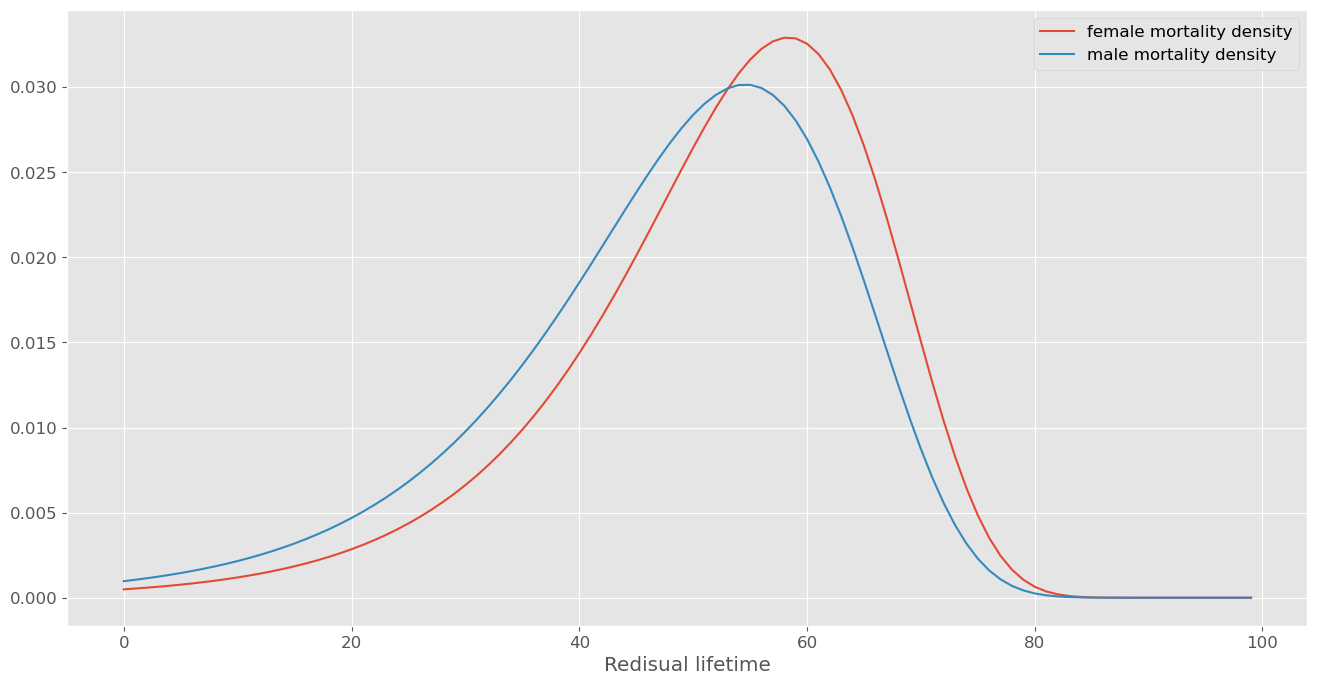

In [ ]:
plt.plot(x,gompertz_density(x,a1,b1), label = 'female mortality density')
plt.plot(x,gompertz_density(x,a2,b2), label = 'male mortality density')
plt.xlabel('Redisual lifetime')
plt.legend()
plt.show()

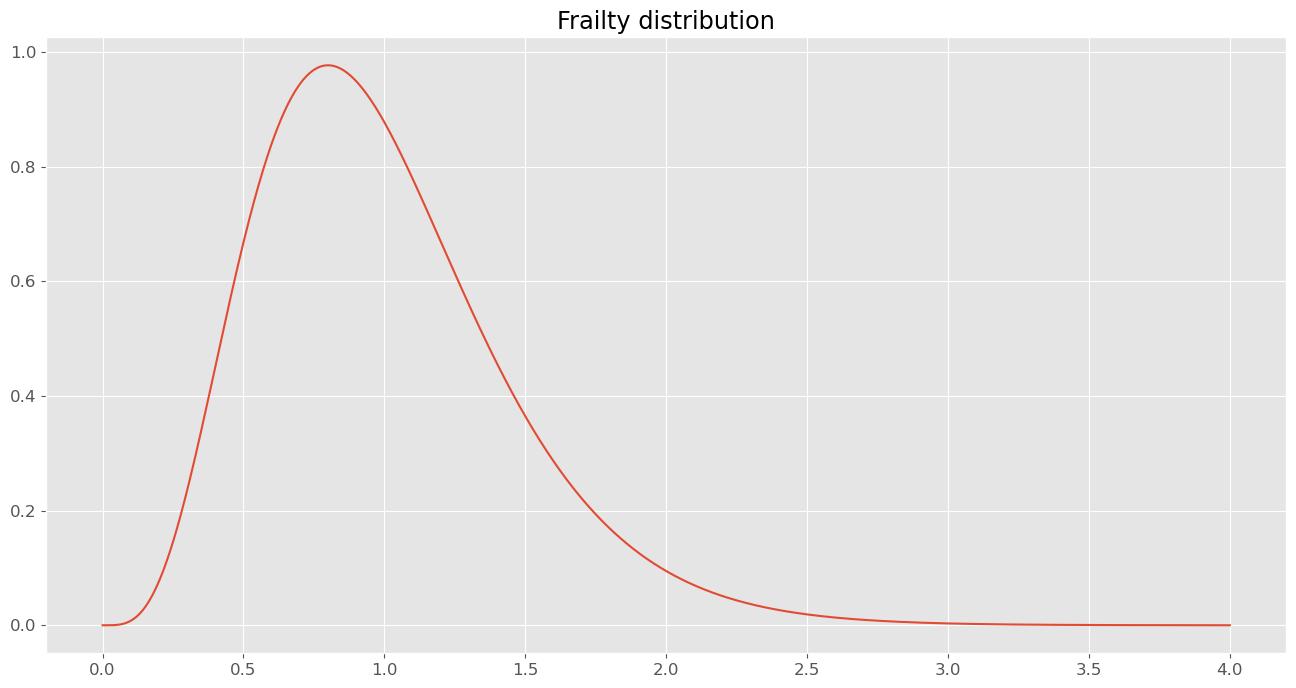

In [ ]:
k = 5
x = np.linspace(0,4,1000)
plt.plot(x, stats.gamma.pdf(x,a = k, scale = 1/k))
plt.title("Frailty distribution")
plt.show()

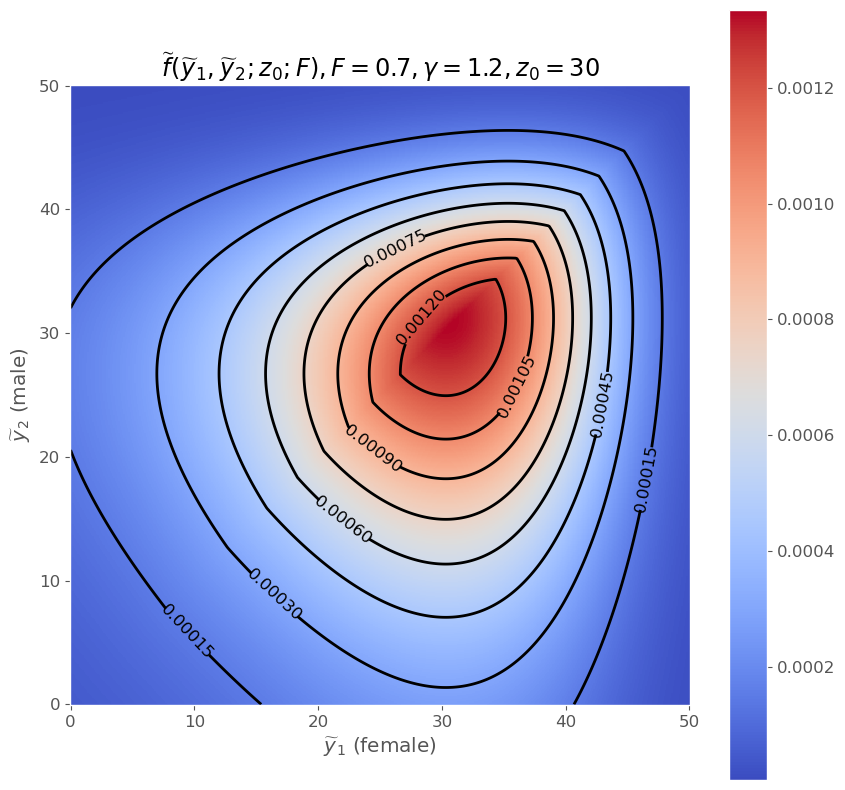

In [ ]:
grid = np.linspace(0,50,500)
y1,y2 = np.meshgrid(grid,grid)
F = 0.7
gamma = 1.2
z0 = 30

levels = 10
cmap = 'coolwarm'

density_F = bivariate_density_conditional_F(y1,y2,z0,a1,b1,a2,b2,gamma,F)

plt.figure(figsize = (10,10))
CSF = plt.pcolormesh(grid,grid,density_F,cmap = cmap)
CS = plt.contour(grid,grid,density_F,linewidths = 2,colors = 'black',levels = levels)
plt.clabel(CS, inline=True)
plt.colorbar(CSF)
plt.title(fr'$\widetilde f(\widetilde y_1,\widetilde y_2;z_0;F), F = {F}, \gamma = {gamma}, z_0 = {z0}$')
plt.xlabel('$\widetilde y_1$ (female)')
plt.ylabel('$\widetilde y_2$ (male)')
plt.gca().set_aspect('equal')
plt.show()

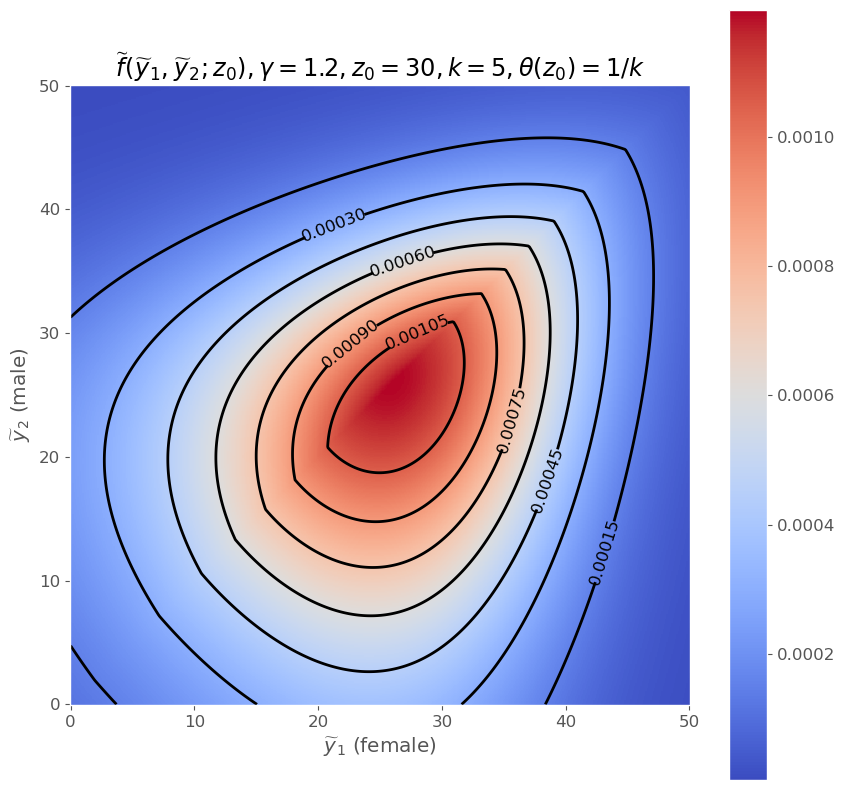

In [ ]:
k = 5
theta = 1/k

levels = 10
cmap = 'coolwarm'

density = bivariate_density_conditional(y1,y2,z0,a1,b1,a2,b2,gamma,k,theta)

plt.figure(figsize = (10,10))
CSF = plt.pcolormesh(grid,grid,density,cmap = cmap)
CS = plt.contour(grid,grid,density,linewidths = 2,colors = 'black',levels = levels)
plt.clabel(CS, inline=True)
plt.colorbar(CSF)
plt.title(fr'$\widetilde f(\widetilde y_1,\widetilde y_2;z_0), \gamma = {gamma}, z_0 = {z0}, k = {k}, \theta(z_0) = 1/k$')
plt.xlabel('$\widetilde y_1$ (female)')
plt.ylabel('$\widetilde y_2$ (male)')
plt.gca().set_aspect('equal')
plt.show()

# Disease history

**Model for the number of diseases**

+ The number of diseases depends only on $F$ and does not depend on future lifetime, given $F$
+ Conditionally on $F$ and $\min(Y_1,Y_2) > z_0$, all variables are independent

$$ \forall z_0 \ge T \ \ \ \  \left\{ N_{i,t} : i\in {1,2}, t\in \{1,\dots,T\} \right\}  | \left ( \min(Y_1,Y_2) > z_0; F  \right) \sim \text {i.i.d } \text {Pois} (\lambda F)$$

**Density given the disease history and survival to $z_0$**:

$$ \text {data} = \left( N_{1,1}, N_{2,1},\dots,N_{1,T}, N_{2,T}  \right), T\le z_0 \\
\widetilde f(\widetilde y_1, \widetilde y_2;z_0;\text{data}) =
\int \frac {f(y_1 + z_0, y_2 + z_0 ;F)} {S_{12}(z_0,z_0;F)} g_{z_0}(F|\text{data})dF \\
g_{z_0}(F|\text{data}) = \frac {\text{Pr}(\text{data}|F,\min(Y_1,Y_2)>z_0)g_{z_0}(F)} {\text{Pr}(\text{data}|\min(Y_1,Y_2)>z_0)}$$

It is known that the gamma distribution $g_{z_0}(F)$ is a conjugate prior for the Poisson distribution. Therefore,

$$ g_{z_0}(F|\text{data}) \sim \Gamma \left(\frac{1}{\theta(z_0)^{-1} + 2\lambda T};k+\sum_{t=1}^T N_{1,t} + N_{2,t} \right) \propto F^{k+\sum_{t=1}^T N_{1,t} + N_{2,t} - 1} \exp[-F/\theta(z_0) -2F\lambda T]$$

Let $k' = k+\sum_{t=1}^T N_{1,t} + N_{2,t}$. From this, for the formula of integration over any gamma distribution:

$$ \widetilde f(\widetilde y_1, \widetilde y_2;z_0;\text{data}) = \\
\frac {a_1(y_1 + z_0) a_2(y_2+z_0) \gamma \Gamma(k'+2) (1/\theta(z_0)+2\lambda T)^{k'}} {\Gamma(k') \left( 1/\theta(z_0) +2\lambda T + A_1(y_1 + z_0) + A_2(y_1 + z_0) + \gamma(A_2(y_2 + z_0)-A_2(y_1 + z_0)) - (A_1(z_0) + A_2(z_0))  \right) ^{k'+2}}, y_1<y_2$$

Symmetrically,

$$ \widetilde f(\widetilde y_1,\widetilde y_2;z_0;\text{data}) = \\
\frac {a_1(y_1 + z_0) a_2(y_2+z_0) \gamma \Gamma(k'+2)(1/\theta(z_0)+2\lambda T)^{k'}} {\Gamma(k')\left( 1/\theta(z_0) + 2\lambda T + A_1(y_2 + z_0) + A_2(y_2 + z_0) + \gamma(A_1(y_1 + z_0)-A_1(y_2 + z_0)) - (A_1(z_0) + A_2(z_0))  \right) ^{k'+2}}, y_2<y_1
$$

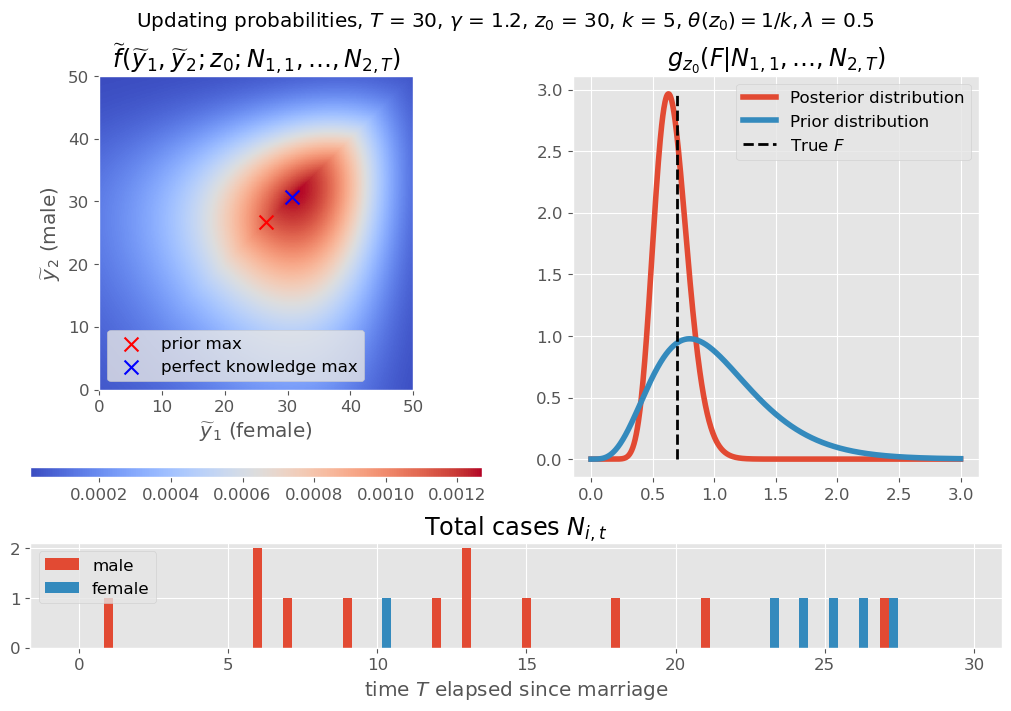

In [ ]:
k = 5
theta = 1/k
F = 0.7
gamma = 1.2
z0 = 30
lambda_ = 0.5

cases1,cases2 = generate_cases(z0,lambda_,F)

evolution_animation(y1,y2,z0,a1,b1,a2,b2,gamma,lambda_,k,theta,F,cases1,cases2,
                   density,density_F)
plt.show()

# Two-dimensional frailty model

**Intensity model**:

$$ a_1(x_1;F) = [wF + (1-w)G_1]a_1(x_1) \\
a_2(x_2;F) = [wF + (1-w)G_2]a_2(x_2)  \\
a_3(x_3;z;F) = G_1a_3(x_3;z)\\
a_4(x_4;z;F) = G_2a_4(x_4;z) $$

+ Frailty distribution given survival to $z_0$:
 $$g_{z_0}(F,G_1,G_2) \sim \text{indep.  } \Gamma(1/k_F,k_F), \Gamma(1/k_G,k_G), \Gamma(1/k_G,k_G) \propto
  F^{k_F-1}G_1^{k_G-1}G_2^{k_G-1}\exp\left[-Fk_F-G_1 k_G-G_2 k_G\right]$$
+ $\text E(F|z_0) = 1, \text E(G_1|z_0) = 1, \text E(G_2|z_0) = 1$
+ $k \in \{2,5,10\}$
     
**Conditional density**:

$$ f(y_1,y_2;F,G_1,G_2) = \begin{cases}
(wF+(1-w)G_1) a_1(y_1) \times \exp \left[- \left( (wF+(1-w)G_1)A_1(y_1) +  (wF+(1-w)G_2)A_2(y_1)\right) \right] \times \\
\gamma G_2 a_2(y_2) \times\exp \left[- \gamma G_2(A_2(y_2)-A_2(y_1))\right], & y_1<y_2 \\
(wF+(1-w)G_2) a_2(y_2) \times \exp \left[- \left( (wF+(1-w)G_1)A_1(y_2) +  (wF+(1-w)G_2)A_2(y_2)\right) \right] \times \\
\gamma G_1 a_1(y_1) \times\exp \left[- \gamma G_1(A_1(y_1)-A_1(y_2))\right], & y_1>y_2
\end{cases} $$
     
**Integration of the conditional density $\widetilde f(\widetilde y_1,\widetilde y_2;z_0;F,G_1,G_2)$**

Let $$g(F,G_1,G_2) \propto F^{\alpha_F}G_1^{\alpha_{G_1}}G_2^{\alpha_{G_2}}\exp(-F\beta_F-G_1\beta_{G_1}-G_2\beta_{G_2})$$
Then for $y_1<y_2$:

$$\int \widetilde f(\widetilde y_1,\widetilde y_2;z_0;F,G_1,G_2) g(F,G_1,G_2)dFdG_1dG_2 = \\
\int \frac {f(y_1+z_0,y_2+z_0;F,G_1,G_2)} {S_{12}(z_0,z_0;F,G_1,G_2)}
\frac {F^{\alpha_F-1}G_1^{\alpha_{G_1}-1}G_2^{\alpha_{G_2}-1}\exp(-F/\theta_F-G_1/\theta_{G_1}-G_2/\theta_{G_2})}{\theta_F^{\alpha_F}\Gamma(\alpha_F)\theta_{G_1}^{\alpha_{G_1}}\Gamma(\alpha_{G_1})\theta_{G_2}^{\alpha_{G_2}}\Gamma(\alpha_{G_2})}dFdG_1dG_2 = \\
\frac {a_1(y_1 + z_0) a_2(y_2+z_0) \gamma}
{\theta_F^{\alpha_F}\Gamma(\alpha_F)\theta_{G_1}^{\alpha_{G_1}}
\Gamma(\alpha_{G_1})\theta_{G_2}^{\alpha_{G_2}}\Gamma(\alpha_{G_2})} \times \int  (wF+(1-w)G_1)G_2 \\
\exp \left [ - F \left( 1/\theta_F + wA_1(y_1 + z_0) + wA_2(y_1 + z_0)- w(A_1(z_0) + A_2(z_0))  \right) \\
-G_1\left( 1/\theta_{G_1} + (1-w)A_1(y_1 + z_0)- (1-w)A_1(z_0)  \right) \\
-G_2\left( 1/\theta_{G_2} + (1-w)A_2(y_1 + z_0) + \gamma(A_2(y_2 + z_0)-A_2(y_1 + z_0)) - (1-w)A_2(z_0)  \right)\right] dF = \\
\left \{  \int F^{k+1} \exp(-Fn)dF = \frac {\Gamma(k+2)}{n^{k+2}}\right \} = \\
a_1(y_1 + z_0) a_2(y_2+z_0) \gamma \times
\frac {\hat\theta_F^{\alpha_F}\hat\theta_{G_1}^{\alpha_{G_1}}\hat\theta_{G_2}^{\alpha_{G_2}}}
{\theta_F^{\alpha_F}\theta_{G_1}^{\alpha_{G_1}}\theta_{G_2}^{\alpha_{G_2}}} \times
\alpha_{G_2} \hat\theta_{G_2} \left [ w \alpha_F \hat\theta_F + (1-w) \alpha_{G_1} \hat\theta_{G_1} \right ], \\
\hat\theta_F = \left( 1/\theta_F + wA_1(y_1 + z_0) + wA_2(y_1 + z_0)- w(A_1(z_0) + A_2(z_0))  \right)^{-1} \\
\hat\theta_{G_1} = \left( 1/\theta_{G_1} + (1-w)A_1(y_1 + z_0)- (1-w)A_1(z_0)  \right)^{-1} \\
\hat\theta_{G_2} = \left( 1/\theta_{G_2} + (1-w)A_2(y_1 + z_0) +
\gamma(A_2(y_2 + z_0)-A_2(y_1 + z_0)) - (1-w)A_2(z_0)  \right) ^{-1}\\
$$

And, for $y_2<y_1$:

$$\int \widetilde f(\widetilde y_1,\widetilde y_2;z_0;F,G_1,G_2) g(F,G_1,G_2)dFdG_1dG_2 = \\
a_1(y_1 + z_0) a_2(y_2+z_0) \gamma \times
\frac {\hat\theta_F^{\alpha_F}\hat\theta_{G_1}^{\alpha_{G_1}}\hat\theta_{G_2}^{\alpha_{G_2}}}
{\theta_F^{\alpha_F}\theta_{G_1}^{\alpha_{G_1}}\theta_{G_2}^{\alpha_{G_2}}} \times
\alpha_{G_1} \hat\theta_{G_1} \left [ w \alpha_F \hat\theta_F + (1-w) \alpha_{G_2} \hat\theta_{G_2} \right ], \\
\hat\theta_F = \left( 1/\theta_F + wA_1(y_2 + z_0) + wA_2(y_2 + z_0)- w(A_1(z_0) + A_2(z_0))  \right)^{-1} \\
\hat\theta_{G_1} = \left( 1/\theta_{G_1} + (1-w)A_1(y_2 + z_0) +
\gamma(A_1(y_1 + z_0)-A_1(y_2 + z_0)) - (1-w)A_1(z_0)  \right) ^{-1}\\
\hat\theta_{G_2} = \left( 1/\theta_{G_2} + (1-w)A_2(y_2 + z_0)- (1-w)A_2(z_0)  \right)^{-1} \\
$$


In [ ]:
from libs.multivariate_static_frailty.math import *
from libs.multivariate_static_frailty.plotting import *

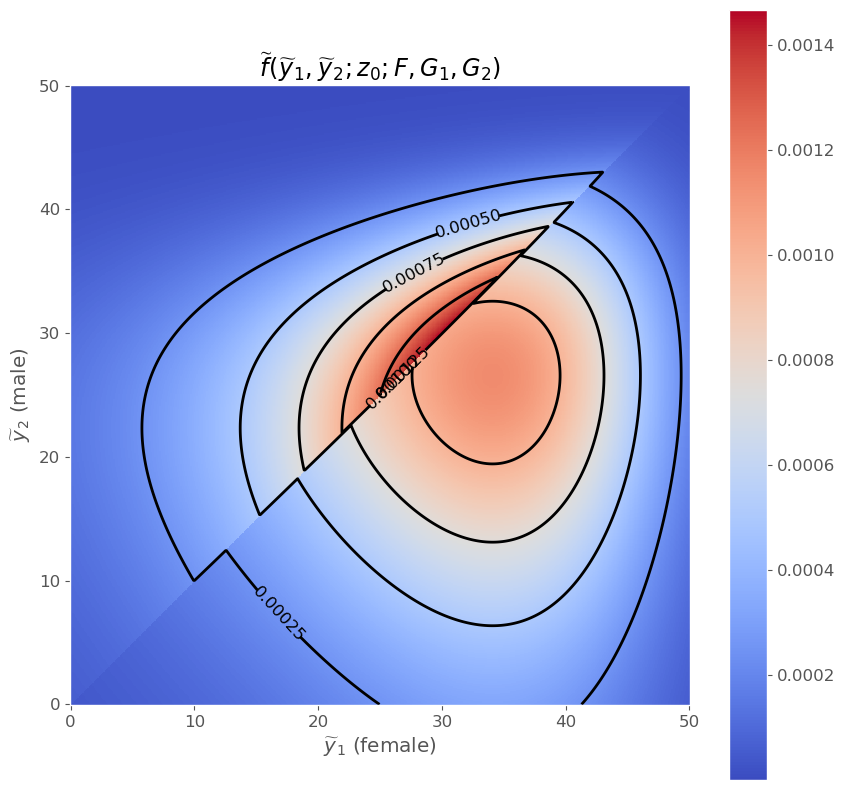

In [ ]:
grid = np.linspace(0,50,500)
y1,y2 = np.meshgrid(grid,grid)
F = 0.7
G1 = 0.5
G2 = 1.0
w = 0.5
gamma = 1.2
lambda_ = 0.5
z0 = 30

levels = 5
cmap = 'coolwarm'

density_FG = bivariate_density_conditional_FG(y1,y2,z0,a1,b1,a2,b2,gamma,F,G1,G2,w)

plt.figure(figsize = (10,10))
CSF = plt.pcolormesh(grid,grid,density_FG,cmap = cmap)
CS = plt.contour(grid,grid,density_FG,linewidths = 2,colors = 'black',levels = levels)
plt.clabel(CS, inline=True)
plt.colorbar(CSF)
plt.title(fr'$\widetilde f(\widetilde y_1,\widetilde y_2;z_0;F,G_1,G_2)$')
plt.xlabel('$\widetilde y_1$ (female)')
plt.ylabel('$\widetilde y_2$ (male)')
plt.gca().set_aspect('equal')
plt.show()

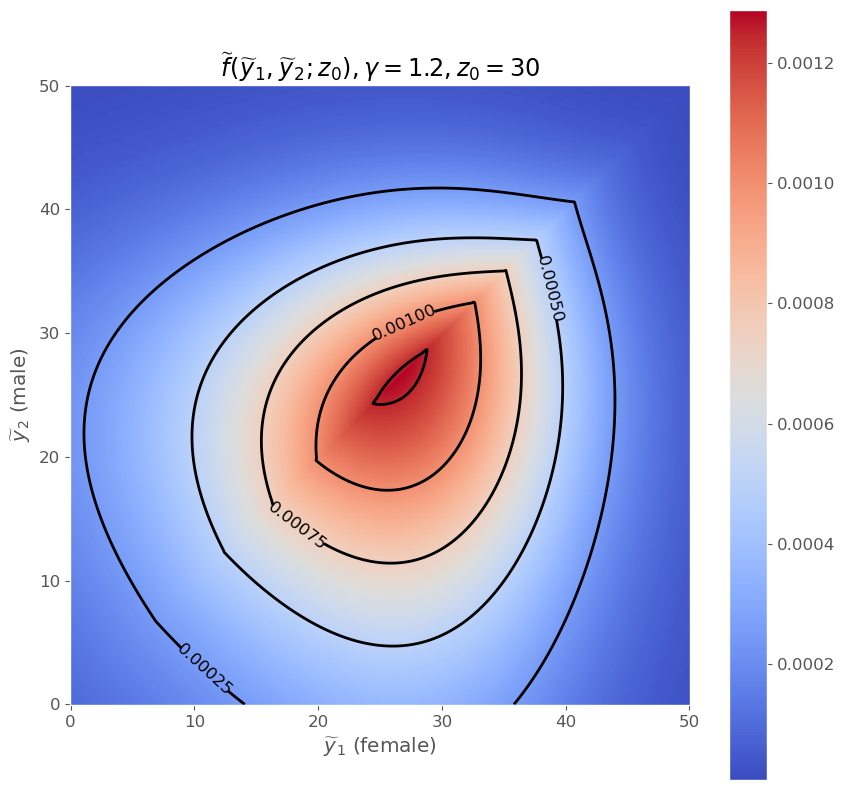

In [ ]:
kF = kG_1 = kG_2 = 5
thetaF = thetaG_1 = thetaG_2 = 1/kF

levels = 5
cmap = 'coolwarm'

density = bivariate_density_conditional_ndim(y1,y2,z0,a1,b1,a2,b2,gamma,kF,thetaF,kG_1,thetaG_1,kG_2,thetaG_2,w)

plt.figure(figsize = (10,10))
CSF = plt.pcolormesh(grid,grid,density,cmap = cmap)
CS = plt.contour(grid,grid,density,linewidths = 2,colors = 'black',levels = levels)
plt.clabel(CS, inline=True)
plt.colorbar(CSF)
plt.title(fr'$\widetilde f(\widetilde y_1,\widetilde y_2;z_0), \gamma = {gamma}, z_0 = {z0}$')
plt.xlabel('$\widetilde y_1$ (female)')
plt.ylabel('$\widetilde y_2$ (male)')
plt.gca().set_aspect('equal')
plt.show()

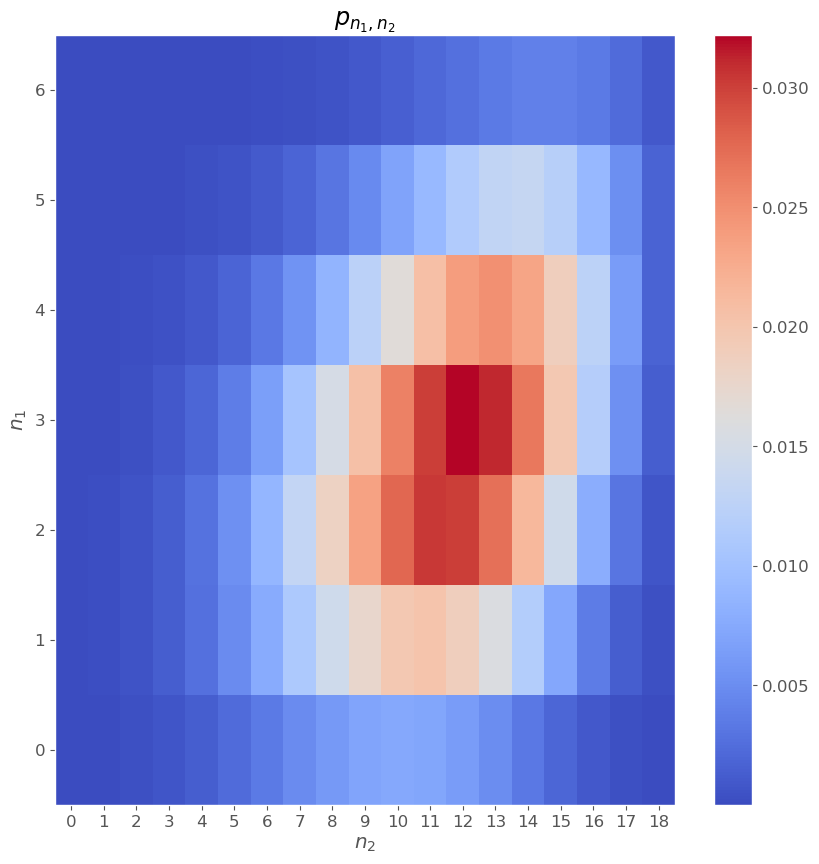

In [ ]:
cases1,cases2 = generate_cases_ndim(z0,lambda_,F,G1,G2,w,seed = 17)
total_cases1 = cases1.sum()
total_cases2 = cases2.sum()

levels = 5
cmap = 'coolwarm'

weights = compute_gamma_weights(kF,thetaF,kG_1,thetaG_1,kG_2,thetaG_2,total_cases1,total_cases2,lambda_,z0, w)

plt.figure(figsize = (10,10))
CSF = plt.pcolormesh(weights,cmap = cmap,antialiased=True)
plt.colorbar(CSF)
plt.title(r'$p_{n_1,n_2}$')
plt.xlabel('$n_2$')
plt.ylabel('$n_1$')
plt.xticks(np.arange(total_cases2+1)+0.5,np.arange(total_cases2+1))
plt.yticks(np.arange(total_cases1+1)+0.5,np.arange(total_cases1+1))
#plt.gca().set_aspect('equal')
plt.show()

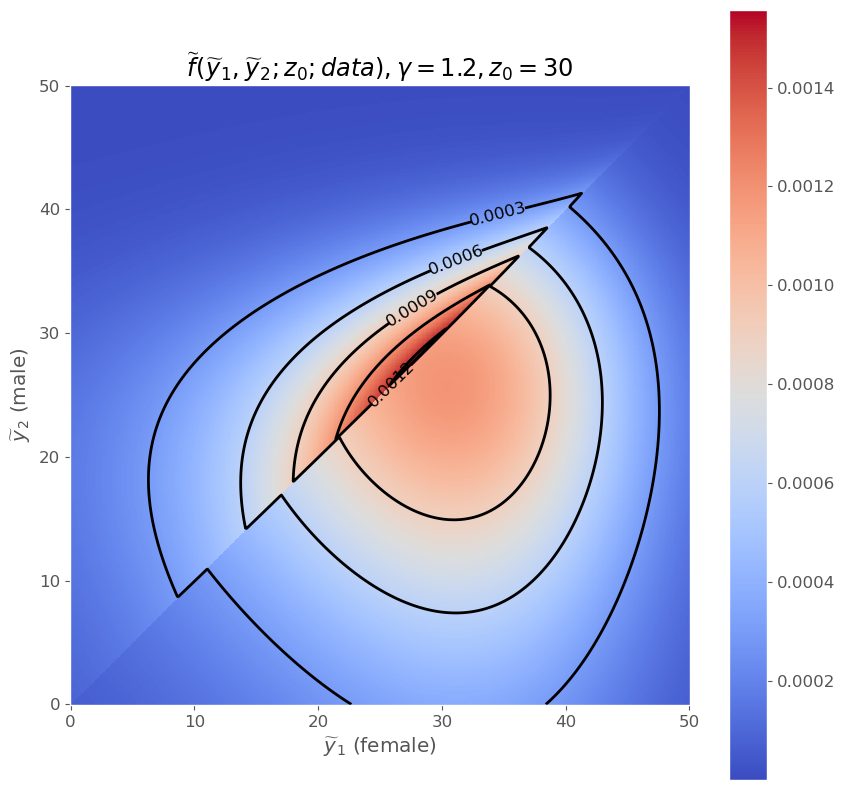

In [ ]:
density_post = bivariate_density_conditional_data_ndim(y1,y2,z0,a1,b1,a2,b2,gamma,
               kF,thetaF,kG_1,thetaG_1,kG_2,thetaG_2,total_cases1,total_cases2,lambda_,z0, w)

levels = 5
cmap = 'coolwarm'

plt.figure(figsize = (10,10))
CSF = plt.pcolormesh(grid,grid,density_post,cmap = cmap)
CS = plt.contour(grid,grid,density_post,linewidths = 2,colors = 'black',levels = levels)
plt.clabel(CS, inline=True)
plt.colorbar(CSF)
plt.title(fr'$\widetilde f(\widetilde y_1,\widetilde y_2;z_0;data), \gamma = {gamma}, z_0 = {z0}$')
plt.xlabel('$\widetilde y_1$ (female)')
plt.ylabel('$\widetilde y_2$ (male)')
plt.gca().set_aspect('equal')
plt.show()

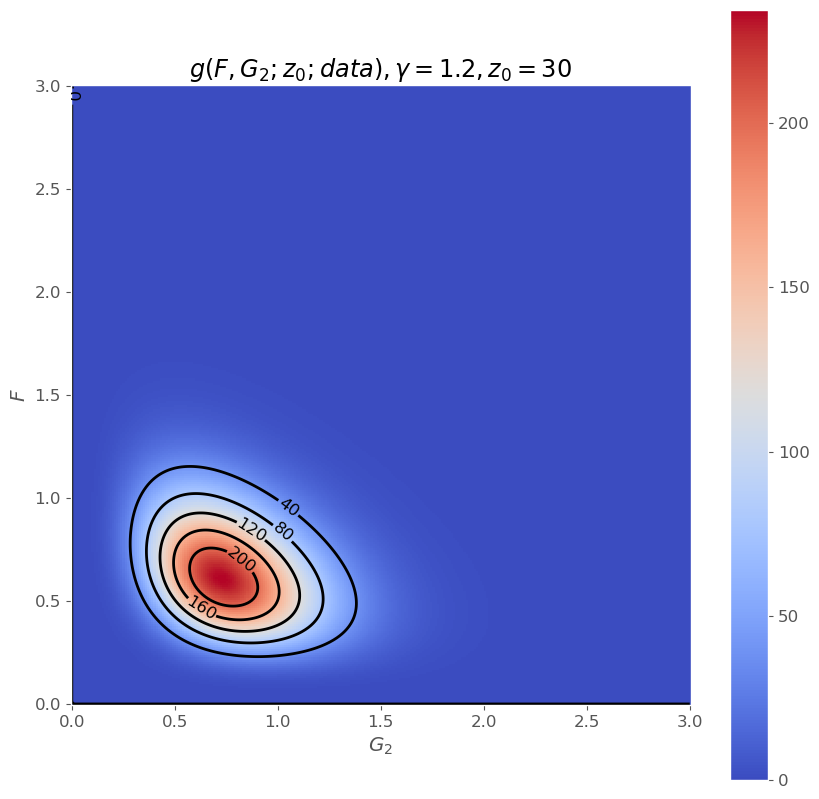

In [ ]:
f_grid = np.linspace(0,3,300)
g1_grid = np.linspace(0,3,300)
g2_grid = np.linspace(0,3,300)

dV = 1e-6

f,g1,g2 = np.meshgrid(f_grid,g1_grid,g2_grid, indexing='ij')

post_density = posterior_gamma_ndim(f_grid,g1_grid,g2_grid,
               total_cases1,total_cases2,z0,lambda_,kF,thetaF,kG_1,thetaG_1,kG_2,thetaG_2,w)

plt.figure(figsize = (10,10))
CSF = plt.pcolormesh(g2_grid,f_grid,post_density.sum(axis = 1),cmap = cmap)
CS = plt.contour(g2_grid,f_grid,post_density.sum(axis = 1),linewidths = 2,colors = 'black',levels = levels)
plt.clabel(CS, inline=True)
plt.colorbar(CSF)
plt.title(fr'$g(F,G_2;z_0;data), \gamma = {gamma}, z_0 = {z0}$')
plt.xlabel('$G_2$')
plt.ylabel('$F$')
plt.gca().set_aspect('equal')
plt.show()

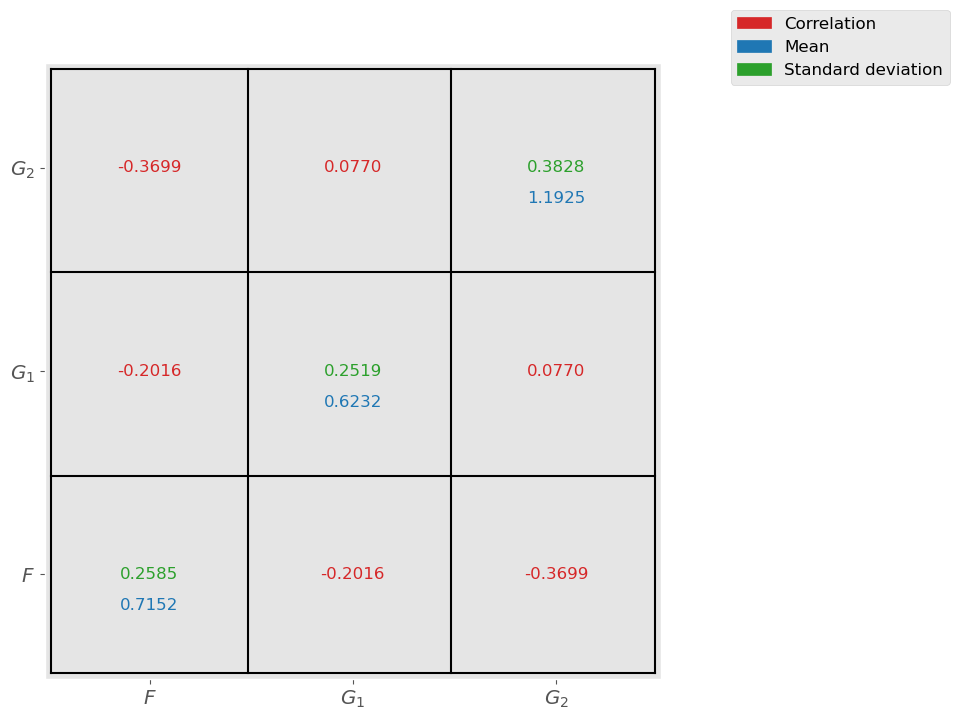

In [ ]:
cases1,cases2 = generate_cases_ndim(z0,lambda_,F,G1,G2,w,seed = 57)
total_cases1 = cases1.sum()
total_cases2 = cases2.sum()


cov, mean = posterior_gamma_moments(total_cases1,total_cases2,z0,lambda_,
                         kF,thetaF,kG_1,thetaG_1,kG_2,thetaG_2,w)

draw_matrix(plt.gca(),cov,mean)
plt.show()

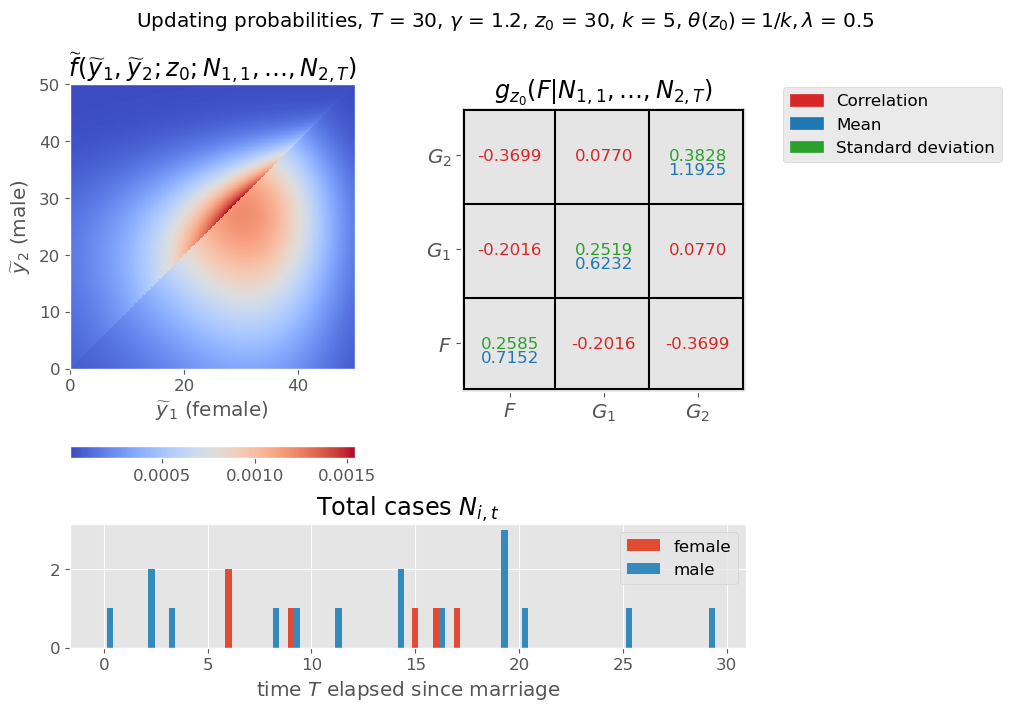

In [ ]:
evolution_animation_ndim(y1,y2,z0,a1,b1,a2,b2,gamma,lambda_,
                         kF,thetaF,kG_1,thetaG_1,kG_2,thetaG_2,cases1,cases2)
plt.show()

# Dynamic frailty model

$$ F_{n-x} = F_n, n\in \mathbb N, 0 \le x < 1 \\
f_t = \frac{F_t}{F}$$

**AR(1)**

Specification of processes:

$$ \log F_t = (1-\rho_F) \log \mu_F + \rho_F \log F_{t-1} + \sigma_F\varepsilon^F_t \\
\log G_{1,t} = (1-\rho_{G_1}) \log \mu_{G_1} + \rho_{G_1} \log G_{1,t-1}+ \sigma_{G_1} \varepsilon^{G_1}_t \\
\log G_{2,t} = (1-\rho_{G_2}) \log \mu_{G_2} + \rho_{G_2} \log G_{2,t-1}+ \sigma_{G_2} \varepsilon^{G_2}_t $$

Constraints on coefficients:

$$ \text E \left [ F_t | F\right ] = \mu_F \exp \left ( - \frac {\sigma_F^2} {2(1-\rho_{G_1}^2)} \right ) = F,
\mu_F = \exp \left (\frac {\sigma_F^2} {2(1-\rho_F^2)} \right ) F \\
\text E \left [ G_{1,t} | G_1\right ] = \mu_{G_1} \exp \left ( - \frac {\sigma_{G_1}^2} {2(1-\rho_{G_1}^2)} \right ) = G_1,
\mu_{G_1} = \exp \left (\frac {\sigma_{G_1}^2} {2(1-\rho_{G_1}^2)} \right ) G_1 \\
\text E \left [ G_{2,t} | G_2\right ] = \mu_{G_2} \exp \left ( - \frac {\sigma_{G_2}^2} {2(1-\rho_{G_2}^2)} \right ) = G_2,
\mu_{G_2} = \exp \left (\frac {\sigma_{G_2}^2} {2(1-\rho_{G_2}^2)} \right ) G_2
$$

**Binary Markov Chain**

Specification of processes:

$$ F_t \in \{d_F F,u_F F\} \\
G_{1,t} \in \{d_{G_1} G_1,u_{G_1} G_1\} \\
G_{2,t} \in \{d_{G_2} G_2,u_{G_2} G_2\} $$

$$
P = \begin {bmatrix}
p_{dd} & p_{du} \\
p_{ud} & p_{uu} \\
\end{bmatrix}
$$

Stationary distribution:

$$
\begin {bmatrix}
p_d & p_u
\end{bmatrix}
\begin {bmatrix}
p_{dd} & p_{du} \\
p_{ud} & p_{uu} \\
\end{bmatrix} =
\begin {bmatrix}  
p_d & p_u
\end{bmatrix} \\
\begin {bmatrix}
p_d & p_u
\end{bmatrix}
\begin {bmatrix}
-p_{du} & p_{du} \\
p_{ud} & -p_{ud} \\
\end{bmatrix} = 0 \implies
\begin {bmatrix}
p_d & p_u
\end{bmatrix} =
\frac {1} {p_{ud} + p_{du}}\begin {bmatrix}
p_{ud} & p_{du}
\end{bmatrix}
$$

Distribution of $f_t$ given survival to $z_0$:

$$ g_z(f_t) = \text P \left(F_t|F, \min(Y_1,Y_2) > z\right) $$

Constraints on coefficients:

$$ \frac{d p_{ud} + u p_{du}}{ p_{ud} + p_{du}} = 1 $$

**Intensity model**:

$$ a_1(x_1;F_{x_1},G_{1,x_1},G_{2,x_1}) = [wF_{x_1} + (1-w)G_{1,x_1}]a_1(x_1) \\
a_2(x_2;F_{x_2},G_{1,x_2},G_{2,x_2}) = [wF_{x_2} + (1-w)G_{2,x_2}]a_2(x_2) \\
a_3(x_3;z;F_{x_1},G_{1,x_1+z},G_{2,x_1+z}) = G_{1,x_3+z}a_3(x_3;z)\\
a_4(x_4;z;F_{x_1},G_{1,x_1+z},G_{2,x_1+z}) =  G_{2,x_4+z}a_4(x_4;z) $$

## Binary series

**Frailty distribution given survival to $z_0$**.

$$ g_{z+1}(F,G_1,G_2) \propto \text P \left( \min (Y_1,Y_2) > z+1 |
\min (Y_1,Y_2) > z, F,G_1,G_2 \right) g_z(F,G_1,G_2) = \\
\sum_{f_{z+1},g_{1,z+1},g_{2,z+1}\in\{d,u\}}  P \left( \min (Y_1,Y_2) > z+1 |
\min (Y_1,Y_2) > z, F,G_1,G_2,f_{z+1},g_{1,z+1},g_{2,z+1} \right)
g_{z}(f_{z+1},g_{1,z+1},g_{2,z+1}) g_z(F,G_1,G_2)
$$

The distribution factorizes:

$$ g_{z+1}(F,G_1,G_2) = g_{z+1}(F)g_{z+1}(G_1)g_{z+1}(G_2) \\
g_{z+1}(F) \propto \sum_{f_{z+1}\in\{d,u\}}\exp \left[- \int_z^{z+1}
wF_{z+1} (a_1(t)+a_2(t))  dt \right]g_{z}(f_{z+1}) g_z(F)
$$

**Distribution of $g_{z}(f_{z+1})$ and $g_{z}(f_{z})$:**

$$
g_{z+1}(f_{z+1},g_{1,z+1},g_{2,z+1}) \propto
\text P \left( \min (Y_1,Y_2) > z+1 |
\min (Y_1,Y_2) > z, F,G_1,G_2, f_{z+1},g_{1,z+1},g_{2,z+1}\right)g_{z}(f_{z+1},g_{1,z+1},g_{2,z+1}) = \\
 \exp \left[- \int_z^{z+1}
\left( (wF_{z+1}+(1-w)G_{1,z+1})a_1(t) + (wF_{z+1}+(1-w)G_{2,z+1})a_2(t) \right) dt \right]
g_{z}(f_{z+1},g_{1,z+1},g_{2,z+1})\\
g_{z+1}(f_{z+1}) \propto \exp \left[- \int_z^{z+1}
 wF_{z+1}\left ( a_1(t) + a_2(t) \right) dt \right]
g_{z}(f_{z+1})\\
g_{z}(f_{z+1})  =  \sum_{f_{z}\in\{d,u\}} g_{z}(f_{z+1}| f_z)g_{z}(f_z)
$$

In [ ]:
from libs.multivariate_dynamic_frailty.math import *
from libs.multivariate_dynamic_frailty.monte_carlo import *
from libs.multivariate_dynamic_frailty.plotting import *

In [ ]:

transition_matrix = np.array([[0.8,0.2],[0.7,0.3]])
u = 1.7
d = 0.8

a1 = 0.089
b1 = -7.613
a2 = 0.081
b2 = -6.934
F = 0.7
G1 = 0.5
G2 = 1.0
w = 0.5
gamma = 1.2
lambda_ = 0.5
z0 = 30

kF = kG_1 = kG_2 = 5
thetaF = thetaG_1 = thetaG_2 = 1/kF

F_grid = np.linspace(0,4,1000)
G1_grid = np.linspace(0,4,1000)
G2_grid = np.linspace(0,4,1000)

density_F = stats.gamma.pdf(F_grid,a = kF,scale = thetaF)
density_G1 = stats.gamma.pdf(G1_grid,a = kG_1, scale = thetaG_1)
density_G2 = stats.gamma.pdf(G2_grid,a = kG_2, scale = thetaG_2)

frailty_samples = generate_gamma_FG(100,kF,thetaF,kG_1,thetaG_1,kG_2,thetaG_2)
particles = generate_binary_particles_FG(1000,z0,*frailty_samples,*(3*[transition_matrix]),u,u,u,d,d,d)

In [ ]:
conditional_density_F,conditional_density_G1,conditional_density_G2,\
    conditional_density_Ft, conditional_density_G1t, conditional_density_G2t =\
frailty_density_conditional(50,F_grid,G1_grid,G2_grid,density_F,density_G1,density_G2,*(3*[transition_matrix]),
                                u,u,u,d,d,d,a1,b1,a2,b2)

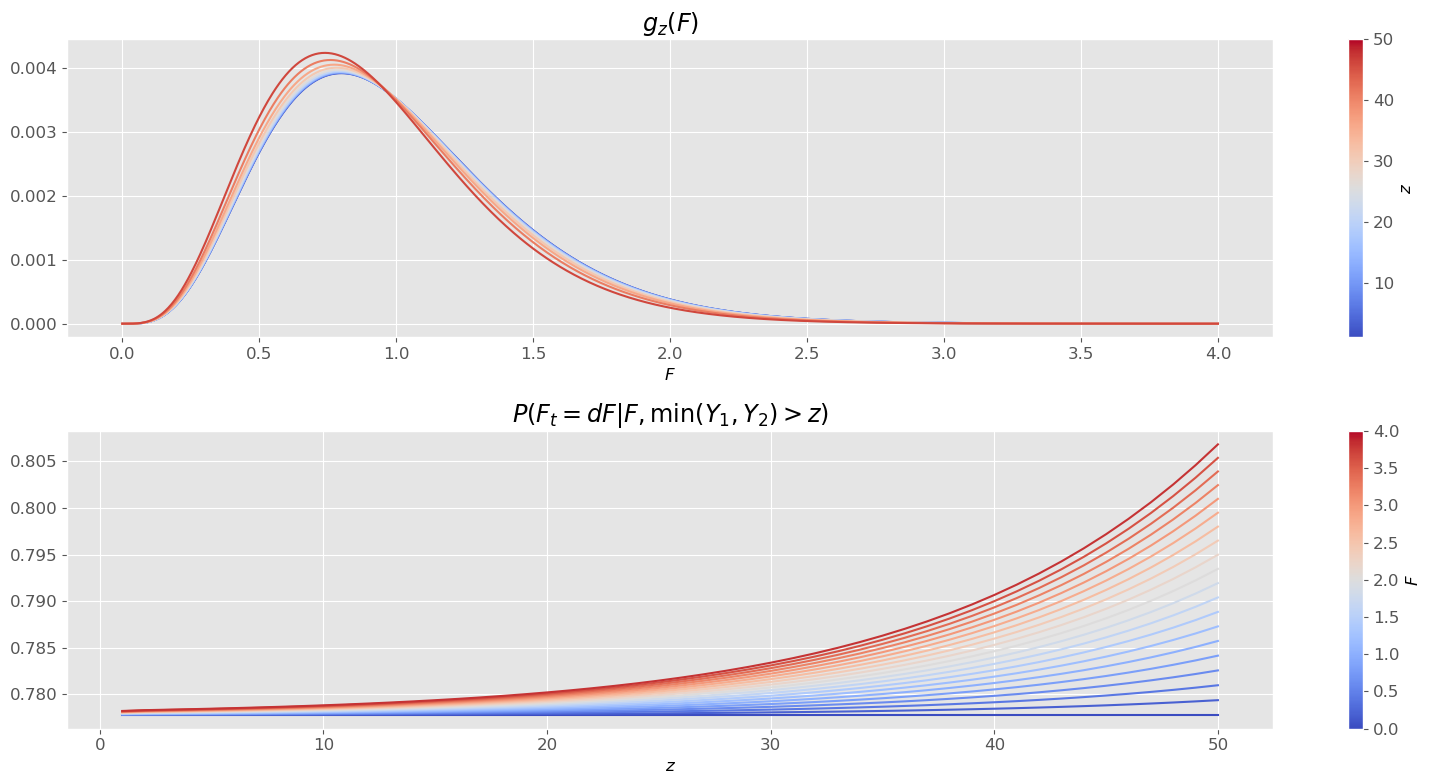

In [ ]:
plot_conditional_frailty(F_grid, conditional_density_F,
                            conditional_density_Ft, letter = 'F')